# Indoor Fingerprinting Localization based on Deep Learning

In [0]:
#Jait Purohit

import sklearn.feature_extraction.text as sk_text
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from pandas import Series
%matplotlib inline
import json
import csv
import pandas as pd
import keras
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D
import time
import seaborn as sns
sns.set_style('whitegrid')
import numpy as np
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
import time
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels
import matplotlib.pyplot as plt
import matplotlib
import pickle
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

Using TensorFlow backend.


In [0]:
import collections
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
from sklearn.metrics import roc_curve, auc

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, collections.Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


In [0]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
# 4/nQGR-xdp25F2tuLBwf1kKyjtJk-HJX5C0wYX_DV2soGrEWSo-HwfH6k

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
pip install geopandas

     |████████████████████████████████| 921kB 3.4MB/s 
     |████████████████████████████████| 10.1MB 43.8MB/s 
     |████████████████████████████████| 11.9MB 39.3MB/s 
  Created wheel for munch: filename=munch-2.3.2-py2.py3-none-any.whl size=6614 sha256=c4f97dcb15c7fb1f9b21f1b0d2b7e5bf6f3da503ec96db830334c296211f4a4e
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch


In [0]:
# Load all importance packages
import geopandas
import numpy as np
import pandas as pd
from shapely.geometry import Point

import missingno as msn

import seaborn as sns
import matplotlib.pyplot as plt

## Deep Learning Algorithms to Estimate/Predict Location

In [0]:
prob_ori_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/masters_project/indoor_rvr_3rd_floor_data copy 2 (1).csv')

In [0]:
prob_ori_df.sample(10)

,'BS 1','BS 2','SF','HDOP',latitude,longitude
93,-91,-94,8,5.732423,-12.0,4.0
46,-71,-69,9,0.640000,-7.5,-2.5
43,-65,-63,10,3.714600,-6.5,-2.5
91,-91,-94,8,5.732423,-12.0,4.0
77,-85,-82,9,7.644563,-12.0,-0.5
41,-65,-63,10,3.714600,-6.5,-2.5
6,-52,-51,8,1.050000,0.0,-1.0
12,-51,-52,7,0.800000,0.0,-2.5
53,-76,-72,10,2.789000,-9.0,-2.5
101,-94,-93,8,5.732423,-12.0,6.0


In [0]:
prob_df1 = prob_ori_df[["'BS 1'","'BS 2'","'SF'","'HDOP'",'latitude','longitude']]

In [0]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude
0,-49,-51,7,0.6,0.0,0.0
1,-49,-51,7,0.6,0.0,0.0
2,-49,-51,7,0.6,0.0,0.0
3,-49,-50,8,0.6,0.0,0.0
4,-50,-50,8,0.6,0.0,0.0


In [0]:
max = prob_df1["'BS 1'"].max()
min = prob_df1["'BS 1'"].min()
prob_df1['normalized_bs1'] = (prob_df1["'BS 1'"] - min)/(max - min)

In [0]:
max = prob_df1["'BS 2'"].max()
min = prob_df1["'BS 2'"].min()
prob_df1['normalized_bs2'] = (prob_df1["'BS 2'"] - min)/(max - min)

In [0]:
max = prob_df1["'SF'"].max()
min = prob_df1["'SF'"].min()
prob_df1['normalized_sf'] = (prob_df1["'SF'"] - min)/(max - min)

In [0]:
max = prob_df1["'HDOP'"].max()
min = prob_df1["'HDOP'"].min()
prob_df1['normalized_hdop'] = (prob_df1["'HDOP'"] - min)/(max - min)

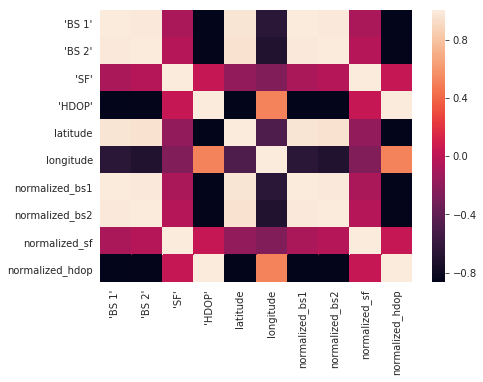

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.heatmap(prob_df1.corr());

In [0]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,-49,-51,7,0.6,0.0,0.0,1.000000,0.977778,0.166667,0.0
1,-49,-51,7,0.6,0.0,0.0,1.000000,0.977778,0.166667,0.0
2,-49,-51,7,0.6,0.0,0.0,1.000000,0.977778,0.166667,0.0
3,-49,-50,8,0.6,0.0,0.0,1.000000,1.000000,0.333333,0.0
4,-50,-50,8,0.6,0.0,0.0,0.978261,1.000000,0.333333,0.0


In [0]:
encode_numeric_zscore(prob_df1, 'latitude', mean=None, sd=None)

In [0]:
encode_numeric_zscore(prob_df1, 'longitude', mean=None, sd=None)

In [0]:
traincols = prob_df1.columns.tolist() 
traincols.remove('latitude')
traincols.remove('longitude')
#traincols.remove('normalized_latitude')
#traincols.remove('normalized_longitude')
traincols.remove("'BS 1'")
traincols.remove("'BS 2'")
traincols.remove("'SF'")
traincols.remove("'HDOP'")
#traincols.remove('distance')
len(traincols)

4

In [0]:
traincols

['normalized_bs1', 'normalized_bs2', 'normalized_sf', 'normalized_hdop']

In [0]:
columns_X = traincols
x = prob_df1[columns_X]
columns_y = ['latitude','longitude']
y = prob_df1[columns_y]

In [0]:
x.head()

,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,1.000000,0.977778,0.166667,0.0
1,1.000000,0.977778,0.166667,0.0
2,1.000000,0.977778,0.166667,0.0
3,1.000000,1.000000,0.333333,0.0
4,0.978261,1.000000,0.333333,0.0


In [0]:
y.head(10)

,latitude,longitude
0,1.563657,0.244479
1,1.563657,0.244479
2,1.563657,0.244479
3,1.563657,0.244479
4,1.563657,0.244479
5,1.563657,-0.122240
6,1.563657,-0.122240
7,1.563657,-0.122240
8,1.563657,-0.122240
9,1.563657,-0.122240


In [0]:
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
def print_report(y_pred,y_true):
    print("Accuracy: ", metrics.accuracy_score(y_true,y_pred))
    print("Precision: ", metrics.precision_score(y_true,y_pred, pos_label=1, average='weighted'))
    print("Recall: ", metrics.recall_score(y_true,y_pred, pos_label=1, average='weighted'))
    print("F1_Score: ", metrics.f1_score(y_true,y_pred, pos_label=1, average='weighted'))
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    outcome = encode_text_index(prob_df1,'longitude','latitude')
    print('Plotting confusion matrix')
    plt.figure()
    plot_confusion_matrix(cm, outcome)
    plt.show()
    print(classification_report(y_true, y_pred))

In [0]:
prob_df1.shape

(105, 10)

In [0]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
1,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
2,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
3,-49,-50,8,0.6,1.563657,0.244479,1.000000,1.000000,0.333333,0.0
4,-50,-50,8,0.6,1.563657,0.244479,0.978261,1.000000,0.333333,0.0


In [0]:
import seaborn as sns
%matplotlib inline

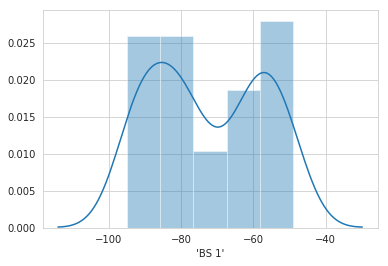

In [0]:
sns.distplot(prob_df1["'BS 1'"])

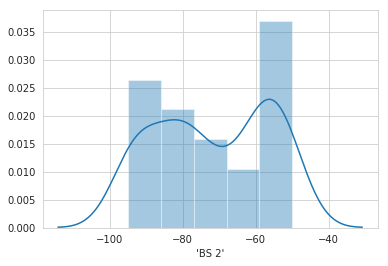

In [0]:
sns.distplot(prob_df1["'BS 2'"])

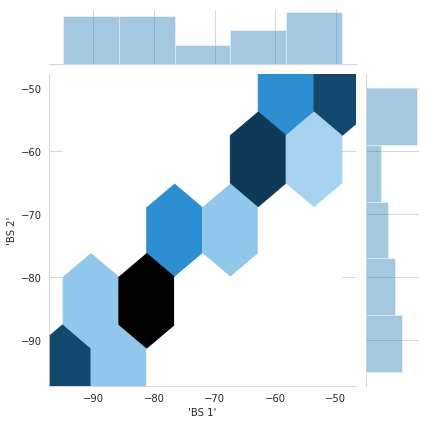

In [0]:
sns.jointplot(x="'BS 1'", y="'BS 2'", data = prob_df1, kind = 'hex')

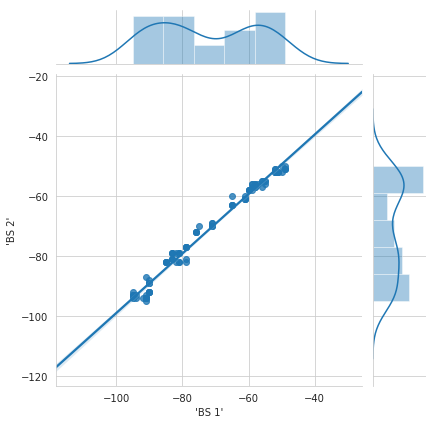

In [0]:
sns.jointplot(x="'BS 1'", y="'BS 2'", data = prob_df1, kind = 'reg')

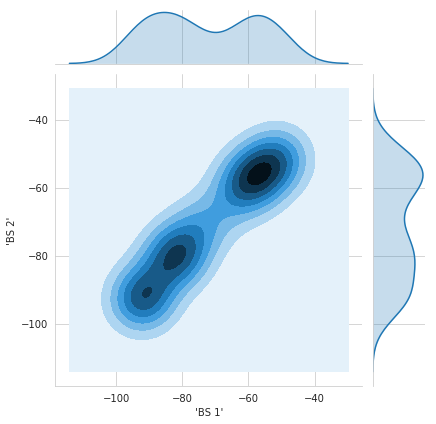

In [0]:
sns.jointplot(x="'BS 1'", y="'BS 2'", data = prob_df1, kind = 'kde')

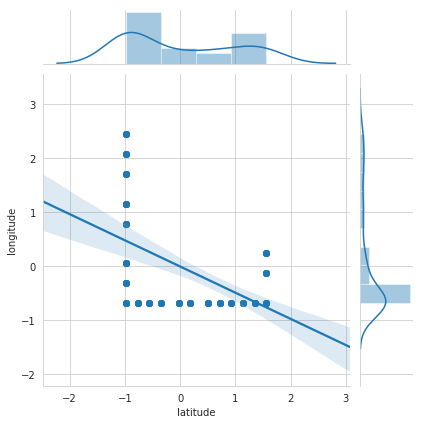

In [0]:
sns.jointplot(x='latitude', y='longitude', data = prob_df1, kind = 'reg')

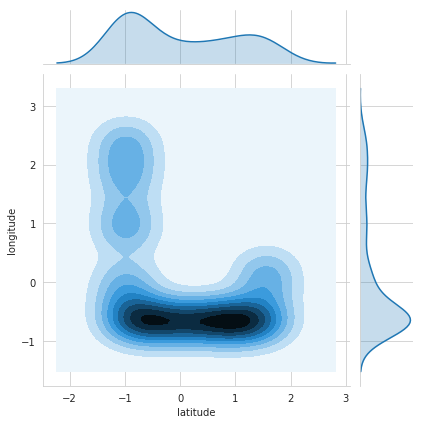

In [0]:
sns.jointplot(x='latitude', y='longitude', data = prob_df1, kind = 'kde')

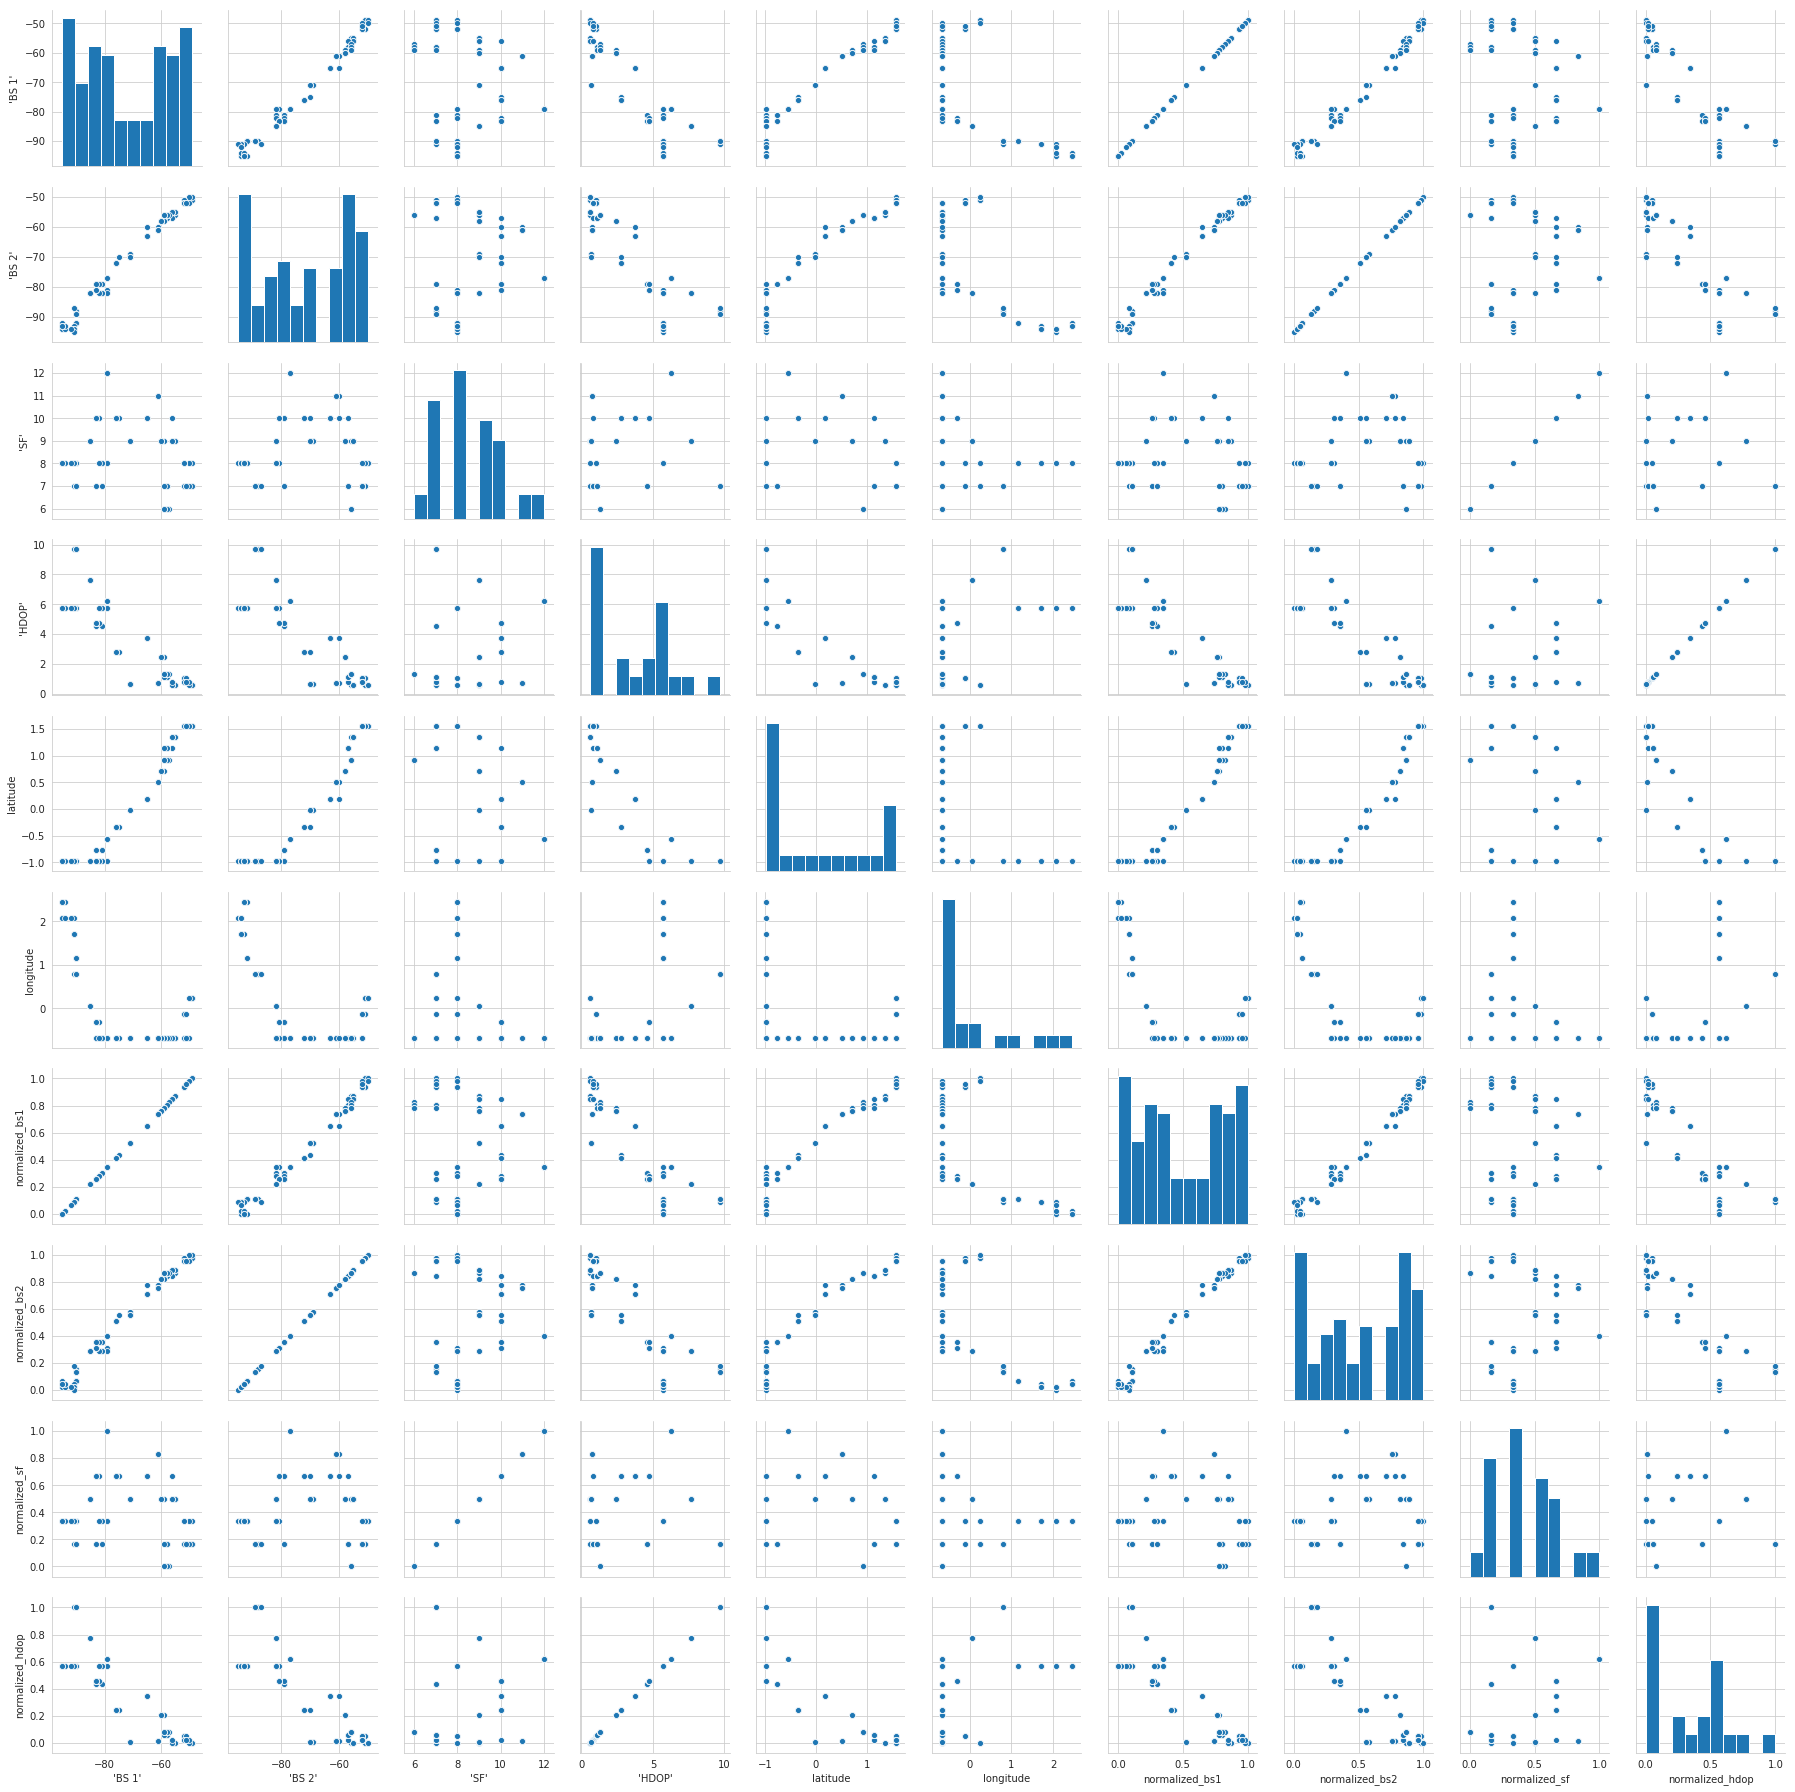

In [0]:
# Pairplot of all numerical value
sns.pairplot(prob_df1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(prob_df1[traincols],prob_df1[columns_y], test_size=0.3, random_state=42)

## Artificial Neural Network

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
import io
import requests
from sklearn import metrics


x_train_ann_class, x_test_ann_class, y_train_ann_class, y_test_ann_class = train_test_split(x,y, test_size=0.25, random_state=42)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    model = Sequential()
    model.add(Dense(60, input_dim=x.shape[1], activation='softmax')) # Hidden 1
    model.add(Dense(30, activation='softmax')) # Hidden 2
    model.add(Dense(15, activation='softmax')) # Hidden 3
    model.add(Dense(2)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train_ann_class, y_train_ann_class, validation_data=(x_test_ann_class,y_test_ann_class), callbacks=[monitor,checkpointer], verbose=0, epochs=10, batch_size=256)  

    

model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass.hdf5')
pred = model.predict(x_test_ann_class)


Epoch 00010: early stopping
Epoch 00006: early stopping
Epoch 00006: early stopping


In [0]:
print(pred)

[[ 0.02404109 -0.01309355]
 [ 0.02403224 -0.01308755]
 [ 0.02403325 -0.01308653]
 [ 0.02403777 -0.01308947]
 [ 0.02404304 -0.01308737]
 [ 0.02403043 -0.01308168]
 [ 0.02402884 -0.01308224]
 [ 0.02404324 -0.01308697]
 [ 0.02404511 -0.01309141]
 [ 0.02404622 -0.01309135]
 [ 0.02404504 -0.01309209]
 [ 0.02404079 -0.01309359]
 [ 0.02403042 -0.01308261]
 [ 0.02403007 -0.01308168]
 [ 0.02402673 -0.01308975]
 [ 0.02404582 -0.01309274]
 [ 0.0240212  -0.01308746]
 [ 0.02404079 -0.01309359]
 [ 0.02404543 -0.01309136]
 [ 0.02404309 -0.01308989]
 [ 0.02402937 -0.01308174]
 [ 0.0240309  -0.01309199]
 [ 0.02404365 -0.0130903 ]
 [ 0.02402673 -0.01308975]
 [ 0.02403768 -0.01309411]
 [ 0.02403326 -0.01308775]
 [ 0.02404555 -0.01309167]]


In [0]:
y_test_ann_class

,latitude,longitude
30,0.716256,-0.672318
65,-0.978547,-0.672318
64,-0.766696,-0.672318
53,-0.342996,-0.672318
45,-0.025220,-0.672318
94,-0.978547,1.711355
104,-0.978547,2.444793
47,-0.025220,-0.672318
10,1.563657,-0.672318
0,1.563657,0.244479


In [0]:
list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)

In [0]:
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)

In [0]:
y_test_ann_class['pred_latitude'] = list_1
y_test_ann_class['pred_longitude'] = list_2
y_test_ann_class

,latitude,longitude,pred_latitude,pred_longitude
30,0.716256,-0.672318,0.024041,-0.013094
65,-0.978547,-0.672318,0.024032,-0.013088
64,-0.766696,-0.672318,0.024033,-0.013087
53,-0.342996,-0.672318,0.024038,-0.013089
45,-0.025220,-0.672318,0.024043,-0.013087
94,-0.978547,1.711355,0.024030,-0.013082
104,-0.978547,2.444793,0.024029,-0.013082
47,-0.025220,-0.672318,0.024043,-0.013087
10,1.563657,-0.672318,0.024045,-0.013091
0,1.563657,0.244479,0.024046,-0.013091


In [0]:
y_test_ann_class['error'] = 
(((y_test_ann_class.latitude.sub(y_test_ann_class['pred_latitude']).pow(2).
                              add(y_test_ann_class.longitude.sub(y_test_ann_class['pred_longitude']).pow(2))).pow(.5)))        

In [0]:
y_test_ann_class

,latitude,longitude,pred_latitude,pred_longitude,error
30,0.716256,-0.672318,0.024041,-0.013094,0.955896
65,-0.978547,-0.672318,0.024032,-0.013088,1.199896
64,-0.766696,-0.672318,0.024033,-0.013087,1.029485
53,-0.342996,-0.672318,0.024038,-0.013089,0.754517
45,-0.025220,-0.672318,0.024043,-0.013087,0.661069
94,-0.978547,1.711355,0.024030,-0.013082,1.994704
104,-0.978547,2.444793,0.024029,-0.013082,2.654488
47,-0.025220,-0.672318,0.024043,-0.013087,0.661069
10,1.563657,-0.672318,0.024045,-0.013091,1.674809
0,1.563657,0.244479,0.024046,-0.013091,1.561007


In [0]:
ann_mean_error = y_test_ann_class['error'].mean()
ann_mean_error

1.324270742484426

## Hyper-tuning Parameters (ANN)

### Sigmoid as Activation Function & Adam as optimizer

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
import io
import requests
from sklearn import metrics


x_train_ann_class, x_test_ann_class, y_train_ann_class, y_test_ann_class = train_test_split(x,y, test_size=0.3, random_state=42)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    model = Sequential()
    model.add(Dense(15, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(10, activation='sigmoid')) # Hidden 2
    model.add(Dense(5, activation='sigmoid')) # Hidden 3
    model.add(Dense(2)) # Output
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train_ann_class, y_train_ann_class, validation_data=(x_test_ann_class,y_test_ann_class), callbacks=[monitor,checkpointer], verbose=2, epochs=15, batch_size = 512)  

    

model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass.hdf5')
pred = model.predict(x_test_ann_class)


list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)
y_test_ann_class['pred_latitude'] = list_1
y_test_ann_class['pred_longitude'] = list_2
y_test_ann_class['error'] = (((y_test_ann_class.latitude.sub(y_test_ann_class['pred_latitude']).pow(2).
                              add(y_test_ann_class.longitude.sub(y_test_ann_class['pred_longitude']).pow(2))).pow(.5)))
y_test_ann_class_1 = y_test_ann_class
ann_hypertune_1 = y_test_ann_class['error'].mean()
ann_hypertune_1

Train on 73 samples, validate on 32 samples
Epoch 1/15
 - 5s - loss: 1.0659 - acc: 0.5479 - val_loss: 1.0130 - val_acc: 0.6250
Epoch 2/15
 - 0s - loss: 1.0636 - acc: 0.5479 - val_loss: 1.0114 - val_acc: 0.6250
Epoch 3/15
 - 0s - loss: 1.0610 - acc: 0.5479 - val_loss: 1.0095 - val_acc: 0.6250
Epoch 4/15
 - 0s - loss: 1.0580 - acc: 0.5479 - val_loss: 1.0077 - val_acc: 0.6250
Epoch 5/15
 - 0s - loss: 1.0551 - acc: 0.5479 - val_loss: 1.0060 - val_acc: 0.6250
Epoch 6/15
 - 0s - loss: 1.0522 - acc: 0.5479 - val_loss: 1.0043 - val_acc: 0.6250
Epoch 7/15
 - 0s - loss: 1.0494 - acc: 0.5479 - val_loss: 1.0027 - val_acc: 0.6250
Epoch 8/15
 - 0s - loss: 1.0467 - acc: 0.5479 - val_loss: 1.0012 - val_acc: 0.6250
Epoch 9/15
 - 0s - loss: 1.0441 - acc: 0.5479 - val_loss: 0.9997 - val_acc: 0.6250
Epoch 10/15
 - 0s - loss: 1.0415 - acc: 0.5479 - val_loss: 0.9984 - val_acc: 0.6250
Epoch 11/15
 - 0s - loss: 1.0390 - acc: 0.5479 - val_loss: 0.9970 - val_acc: 0.6250
Epoch 12/15
 - 0s - loss: 1.0366 - acc: 0

1.270332431977348

In [0]:
y_test_ann_class_1

,latitude,longitude,pred_latitude,pred_longitude,error
30,0.716256,-0.672318,0.128261,-0.184043,0.764297
65,-0.978547,-0.672318,0.126302,-0.187523,1.206531
64,-0.766696,-0.672318,0.126313,-0.187820,1.015974
53,-0.342996,-0.672318,0.127755,-0.186523,0.676463
45,-0.025220,-0.672318,0.127013,-0.187002,0.508632
94,-0.978547,1.711355,0.125034,-0.190230,2.198617
104,-0.978547,2.444793,0.125635,-0.190070,2.856872
47,-0.025220,-0.672318,0.126819,-0.187201,0.508384
10,1.563657,-0.672318,0.127696,-0.183966,1.516731
0,1.563657,0.244479,0.127539,-0.183860,1.498636


### Sigmoid as Activation Function, RMSProp as Optimizer, Neuron Counts

In [0]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import os
import io
import requests
from sklearn import metrics


x_train_ann_class, x_test_ann_class, y_train_ann_class, y_test_ann_class = train_test_split(x,y, test_size=0.3, random_state=42)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(5):
    model = Sequential()
    model.add(Dense(45, input_dim=x.shape[1], activation='sigmoid')) # Hidden 1
    model.add(Dense(30, activation='sigmoid')) # Hidden 2
    model.add(Dense(15, activation='sigmoid')) # Hidden 3
    model.add(Dense(2)) # Output
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    history = model.fit(x_train_ann_class, y_train_ann_class, validation_data=(x_test_ann_class,y_test_ann_class), callbacks=[monitor,checkpointer], verbose=2, epochs=20, batch_size = 256)  

    

model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass.hdf5')
pred = model.predict(x_test_ann_class)


list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)
y_test_ann_class['pred_latitude'] = list_1
y_test_ann_class['pred_longitude'] = list_2
y_test_ann_class['error'] = (((y_test_ann_class.latitude.sub(y_test_ann_class['pred_latitude']).pow(2).
                              add(y_test_ann_class.longitude.sub(y_test_ann_class['pred_longitude']).pow(2))).pow(.5)))
y_test_ann_class_2 = y_test_ann_class
ann_hypertune_2 = y_test_ann_class['error'].mean()
ann_hypertune_2

Train on 73 samples, validate on 32 samples
Epoch 1/20
 - 5s - loss: 1.1836 - acc: 0.5479 - val_loss: 1.0323 - val_acc: 0.6250
Epoch 2/20
 - 0s - loss: 1.1120 - acc: 0.5479 - val_loss: 1.0093 - val_acc: 0.6250
Epoch 3/20
 - 0s - loss: 1.0743 - acc: 0.5479 - val_loss: 0.9961 - val_acc: 0.6250
Epoch 4/20
 - 0s - loss: 1.0497 - acc: 0.5479 - val_loss: 0.9881 - val_acc: 0.6250
Epoch 5/20
 - 0s - loss: 1.0323 - acc: 0.5479 - val_loss: 0.9833 - val_acc: 0.6250
Epoch 6/20
 - 0s - loss: 1.0196 - acc: 0.5479 - val_loss: 0.9807 - val_acc: 0.6250
Epoch 7/20
 - 0s - loss: 1.0101 - acc: 0.5479 - val_loss: 0.9795 - val_acc: 0.6250
Epoch 8/20
 - 0s - loss: 1.0029 - acc: 0.5479 - val_loss: 0.9793 - val_acc: 0.6250
Epoch 9/20
 - 0s - loss: 0.9975 - acc: 0.5479 - val_loss: 0.9797 - val_acc: 0.6250
Epoch 10/20
 - 0s - loss: 0.9933 - acc: 0.5479 - val_loss: 0.9806 - val_acc: 0.6250
Epoch 11/20
 - 0s - loss: 0.9902 - acc: 0.5479 - val_loss: 0.9817 - val_acc: 0.6250
Epoch 12/20
 - 0s - loss: 0.9877 - acc: 0

1.2867587639425788

In [0]:
y_test_ann_class_2

,latitude,longitude,pred_latitude,pred_longitude,error
30,0.716256,-0.672318,0.066703,-0.091622,0.871279
65,-0.978547,-0.672318,0.063082,-0.088182,1.194239
64,-0.766696,-0.672318,0.065459,-0.087658,1.017010
53,-0.342996,-0.672318,0.065376,-0.088317,0.712618
45,-0.025220,-0.672318,0.068101,-0.089165,0.590573
94,-0.978547,1.711355,0.062492,-0.085897,2.076987
104,-0.978547,2.444793,0.063066,-0.085047,2.735881
47,-0.025220,-0.672318,0.067956,-0.089180,0.590535
10,1.563657,-0.672318,0.069902,-0.092915,1.602190
0,1.563657,0.244479,0.069920,-0.093498,1.531495


## LSTM

In [0]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
1,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
2,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
3,-49,-50,8,0.6,1.563657,0.244479,1.000000,1.000000,0.333333,0.0
4,-50,-50,8,0.6,1.563657,0.244479,0.978261,1.000000,0.333333,0.0


In [0]:
prob_df_lstm = prob_df1[['normalized_bs1','normalized_bs2','normalized_sf','normalized_hdop','latitude','longitude']]

In [0]:
xarray=[]
xarray=prob_df_lstm.as_matrix()

In [0]:
xarray

array([[ 1.00000000e+00,  9.77777778e-01,  1.66666667e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 1.00000000e+00,  9.77777778e-01,  1.66666667e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 1.00000000e+00,  9.77777778e-01,  1.66666667e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 1.00000000e+00,  1.00000000e+00,  3.33333333e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 9.78260870e-01,  1.00000000e+00,  3.33333333e-01,
         0.00000000e+00,  1.56365707e+00,  2.44479273e-01],
       [ 9.34782609e-01,  9.77777778e-01,  3.33333333e-01,
         4.95742101e-02,  1.56365707e+00, -1.22239637e-01],
       [ 9.34782609e-01,  9.77777778e-01,  3.33333333e-01,
         4.95742101e-02,  1.56365707e+00, -1.22239637e-01],
       [ 9.34782609e-01,  9.55555556e-01,  3.33333333e-01,
         4.95742101e-02,  1.56365707e+00, -1.22239637e-01],
       [ 9.34782609e-01,  9.55555556e-01,  1.666

In [0]:
yarray=prob_df1[['latitude','longitude']].as_matrix()

In [0]:
SEQUENCE_SIZE = 1
import numpy as np

def to_sequences(seq_size, data,data2):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [0]:
x,y = to_sequences(SEQUENCE_SIZE,xarray,yarray)

In [0]:
x.shape

(103, 1, 1, 6)

In [0]:
y.shape

(103, 2)

In [0]:
x_rnn = x.reshape(x.shape[0],1,6)

In [0]:
y_rnn = y.reshape(y.shape[0], 2)

In [0]:
x_rnn.shape

(103, 1, 6)

In [0]:
y_rnn.shape

(103, 2)

In [0]:
x_train_lstm = x_rnn[0:75]
y_train_lstm = y_rnn[0:75]
x_test_lstm = x_rnn[75:103]
y_test_lstm = y_rnn[75:103]

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np

# x_train_lstm, y_train_lstm, x_test_lstm, y_test_lstm = train_test_split(x_rnn,y_rnn, test_size=0.3, random_state=42)
checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass1.hdf5", verbose=0, save_best_only=True) # save best model

print('Build model...')
for i in range(5):
    model = Sequential()
    model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.1, input_shape=(1, 6)))
    model.add(Dense(256))
    model.add(Dense(128))
    model.add(Dense(2))
    model.summary()
    model.compile(loss='mean_squared_error', optimizer='adam')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10, batch_size = 512)
     
model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass1.hdf5')
pred = model.predict(x_test_lstm)

Build model...
Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_45 (LSTM)               (None, 512)               1062912   
_________________________________________________________________
dense_393 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_394 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_395 (Dense)            (None, 2)                 258       
Total params: 1,227,394
Trainable params: 1,227,394
Non-trainable params: 0
_________________________________________________________________
Train...
Train on 75 samples, validate on 28 samples
Epoch 1/10
 - 18s - loss: 0.6629 - val_loss: 1.6196
Epoch 2/10
 - 0s - loss: 0.4872 - val_loss: 1.5430
Epoch 3/10
 - 0s - loss: 0.3355 - val_loss: 1.4605
Epoch 4/10
 - 0s -

In [0]:
list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)


In [0]:
pred_lstm_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
pred_lstm_long = pd.DataFrame(list_2, columns =['pred_longitude'])

In [0]:
pred_lstm_lat.head()

,pred_latitude
0,-0.793039
1,-0.793039
2,-0.793039
3,-0.793039
4,-0.793039


In [0]:
pred_lstm_long.head()

,pred_longitude
0,-0.474763
1,-0.474763
2,-0.474763
3,-0.474763
4,-0.474763


In [0]:
list_1 = []
for p in range(len(y_test_lstm)):
  sum = y_test_lstm[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(y_test_lstm)):
  sum1 = y_test_lstm[l][1]
  list_2.append(sum1)

In [0]:
y_test_lstm_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
y_test_lstm_long = pd.DataFrame(list_2, columns =['pred_longitude'])

In [0]:
y_test_lstm_lat.head()

,pred_latitude
0,-0.978547
1,-0.978547
2,-0.978547
3,-0.978547
4,-0.978547


In [0]:
y_test_lstm_long.head()

,pred_longitude
0,0.061120
1,0.061120
2,0.061120
3,0.061120
4,0.794558


In [0]:
y_test_lstm = (((y_test_lstm_lat.pred_latitude.sub(pred_lstm_lat['pred_latitude']).pow(2).
                              add(y_test_lstm_long.pred_longitude.sub(pred_lstm_long['pred_longitude']).pow(2))).pow(.5)))
y_test_lstm_1 = y_test_lstm
lstm_score = y_test_lstm.mean()
lstm_score

1.4091744781253424

In [0]:
y_test_lstm_1 = y_test_lstm_1.to_frame()

In [0]:
y_test_lstm_1

,0
0,0.567084
1,0.567084
2,0.567084
3,0.567084
4,1.282805
5,0.973338
6,0.972967
7,0.969148
8,0.969148
9,1.333025


## Hypertuning Parameters (LSTM)

### Batch Size = 81, Optimizer = RMSProp, Dropout = 0.5



In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np

x_train_lstm = x_rnn[0:75]
y_train_lstm = y_rnn[0:75]
x_test_lstm = x_rnn[75:103]
y_test_lstm = y_rnn[75:103]

checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass1.hdf5", verbose=0, save_best_only=True) # save best model

print('Build model...')
for i in range(5):
    model = Sequential()
    model.add(LSTM(1024, dropout=0.5, recurrent_dropout=0.1, input_shape=(1, 6)))
    model.add(Dense(512))
    model.add(Dense(256))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='rmsprop')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10, batch_size = 81)
     
model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass1.hdf5')
pred = model.predict(x_test_lstm)

list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)
pred_lstm_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
pred_lstm_long = pd.DataFrame(list_2, columns =['pred_longitude'])
list_1 = []
for p in range(len(y_test_lstm)):
  sum = y_test_lstm[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(y_test_lstm)):
  sum1 = y_test_lstm[l][1]
  list_2.append(sum1)
y_test_lstm_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
y_test_lstm_long = pd.DataFrame(list_2, columns =['pred_longitude'])

y_test_lstm = (((y_test_lstm_lat.pred_latitude.sub(pred_lstm_lat['pred_latitude']).pow(2).
                              add(y_test_lstm_long.pred_longitude.sub(pred_lstm_long['pred_longitude']).pow(2))).pow(.5)))
y_test_lstm_2 = y_test_lstm
lstm_score_2 = y_test_lstm.mean()
lstm_score_2

Build model...
Train...
Train on 75 samples, validate on 28 samples
Epoch 1/10
 - 19s - loss: 0.6982 - val_loss: 1.1719
Epoch 2/10
 - 0s - loss: 0.2746 - val_loss: 1.8511
Epoch 3/10
 - 0s - loss: 0.5283 - val_loss: 1.5290
Epoch 4/10
 - 0s - loss: 0.3245 - val_loss: 1.5232
Epoch 5/10
 - 0s - loss: 0.2997 - val_loss: 1.2913
Epoch 6/10
 - 0s - loss: 0.2721 - val_loss: 1.3786
Epoch 00006: early stopping
Train...
Train on 75 samples, validate on 28 samples
Epoch 1/10
 - 19s - loss: 0.6543 - val_loss: 1.2331
Epoch 2/10
 - 0s - loss: 0.2925 - val_loss: 1.6652
Epoch 3/10
 - 0s - loss: 0.3775 - val_loss: 1.1052
Epoch 4/10
 - 0s - loss: 0.3005 - val_loss: 1.6874
Epoch 5/10
 - 0s - loss: 0.2772 - val_loss: 1.4468
Epoch 6/10
 - 0s - loss: 0.2873 - val_loss: 1.5250
Epoch 7/10
 - 0s - loss: 0.2873 - val_loss: 1.4168
Epoch 8/10
 - 0s - loss: 0.2855 - val_loss: 1.5087
Epoch 00008: early stopping
Train...
Train on 75 samples, validate on 28 samples
Epoch 1/10
 - 20s - loss: 0.6779 - val_loss: 1.2760
Ep

1.348190484028025

In [0]:
y_test_lstm_2 = y_test_lstm_2.to_frame()

In [0]:
y_test_lstm_2

,0
0,0.452812
1,0.452812
2,0.452812
3,0.452812
4,1.049484
5,0.859504
6,0.861376
7,0.854714
8,0.854714
9,1.188752


### Optimizer = SGD, Batch-Size = 256, Dropout = 0.3

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np

x_train_lstm = x_rnn[0:75]
y_train_lstm = y_rnn[0:75]
x_test_lstm = x_rnn[75:103]
y_test_lstm = y_rnn[75:103]

checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass1.hdf5", verbose=0, save_best_only=True) # save best model

print('Build model...')
for i in range(5):
    model = Sequential()
    model.add(LSTM(1024, dropout=0.3, recurrent_dropout=0.1, input_shape=(1, 6)))
    model.add(Dense(512))
    model.add(Dense(256))
    model.add(Dense(2))
    model.compile(loss='mean_squared_error', optimizer='sgd')
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    print('Train...')
    model.fit(x_train_lstm,y_train_lstm,validation_data=(x_test_lstm,y_test_lstm),callbacks=[monitor,checkpointer],verbose=2, epochs=10, batch_size = 256)
     
model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass1.hdf5')
pred = model.predict(x_test_lstm)

list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)
pred_lstm_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
pred_lstm_long = pd.DataFrame(list_2, columns =['pred_longitude'])
list_1 = []
for p in range(len(y_test_lstm)):
  sum = y_test_lstm[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(y_test_lstm)):
  sum1 = y_test_lstm[l][1]
  list_2.append(sum1)
y_test_lstm_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
y_test_lstm_long = pd.DataFrame(list_2, columns =['pred_longitude'])

y_test_lstm = (((y_test_lstm_lat.pred_latitude.sub(pred_lstm_lat['pred_latitude']).pow(2).
                              add(y_test_lstm_long.pred_longitude.sub(pred_lstm_long['pred_longitude']).pow(2))).pow(.5)))
y_test_lstm_3 = y_test_lstm
lstm_score_3 = y_test_lstm.mean()
lstm_score_3

Build model...
Train...
Train on 75 samples, validate on 28 samples
Epoch 1/10
 - 21s - loss: 0.6945 - val_loss: 1.7878
Epoch 2/10
 - 0s - loss: 0.6573 - val_loss: 1.8526
Epoch 3/10
 - 0s - loss: 0.6249 - val_loss: 1.9135
Epoch 4/10
 - 0s - loss: 0.5968 - val_loss: 1.9706
Epoch 5/10
 - 0s - loss: 0.5687 - val_loss: 2.0243
Epoch 6/10
 - 0s - loss: 0.5504 - val_loss: 2.0753
Epoch 00006: early stopping
Train...
Train on 75 samples, validate on 28 samples
Epoch 1/10
 - 21s - loss: 0.6875 - val_loss: 1.8179
Epoch 2/10
 - 0s - loss: 0.6593 - val_loss: 1.8745
Epoch 3/10
 - 0s - loss: 0.6358 - val_loss: 1.9283
Epoch 4/10
 - 0s - loss: 0.6112 - val_loss: 1.9793
Epoch 5/10
 - 0s - loss: 0.5853 - val_loss: 2.0277
Epoch 6/10
 - 0s - loss: 0.5670 - val_loss: 2.0742
Epoch 00006: early stopping
Train...
Train on 75 samples, validate on 28 samples
Epoch 1/10
 - 22s - loss: 0.6707 - val_loss: 1.7915
Epoch 2/10
 - 0s - loss: 0.6360 - val_loss: 1.8511
Epoch 3/10
 - 0s - loss: 0.6079 - val_loss: 1.9075
Ep

1.7996896220461454

In [0]:
y_test_lstm_3 = y_test_lstm_3.to_frame()

In [0]:
y_test_lstm_3

,0
0,0.973440
1,0.973440
2,0.973440
3,0.973440
4,1.265498
5,1.273347
6,1.272482
7,1.274002
8,1.274002
9,1.536059


## CNN

In [0]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np

In [0]:
prob_df1.head()

,'BS 1','BS 2','SF','HDOP',latitude,longitude,normalized_bs1,normalized_bs2,normalized_sf,normalized_hdop
0,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
1,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
2,-49,-51,7,0.6,1.563657,0.244479,1.000000,0.977778,0.166667,0.0
3,-49,-50,8,0.6,1.563657,0.244479,1.000000,1.000000,0.333333,0.0
4,-50,-50,8,0.6,1.563657,0.244479,0.978261,1.000000,0.333333,0.0


In [0]:
prob_df_cnn = prob_df1[['normalized_bs1','normalized_bs2','normalized_sf','normalized_hdop','latitude','longitude']]

In [0]:
xarray=[]
xarray=prob_df_cnn.as_matrix()

In [0]:
yarray=prob_df1[['latitude','longitude']].as_matrix()

In [0]:
SEQUENCE_SIZE = 1
import numpy as np

def to_sequences(seq_size, data,data2):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [0]:
x,y = to_sequences(SEQUENCE_SIZE,xarray,yarray)

In [0]:
x_cnn = x.reshape(x.shape[0], 1, 1, 6)
y_cnn = y.reshape(y.shape[0], 2)

In [0]:
x_train_cnn = x_cnn[0:75]
y_train_cnn = y_cnn[0:75]
x_test_cnn = x_cnn[75:103]
y_test_cnn = y_cnn[75:103]

In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 64

import numpy as np
import h5py

f = h5py.File('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5','w')
group = f.create_group('a_group')
f.close()

checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (1, 1, 6)
    model.add(Conv2D(1024, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='relu',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(512, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5')
pred = model.predict(x_test_cnn)

Model: "sequential_144"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 1, 1, 1024)        56320     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 1, 1, 1024)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 1, 1, 512)         4719104   
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 1, 1, 512)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_478 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)            

In [0]:
list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)
pred_cnn_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
pred_cnn_long = pd.DataFrame(list_2, columns =['pred_longitude'])
list_1 = []
for p in range(len(y_test_cnn)):
  sum = y_test_cnn[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(y_test_cnn)):
  sum1 = y_test_cnn[l][1]
  list_2.append(sum1)
y_test_cnn_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
y_test_cnn_long = pd.DataFrame(list_2, columns =['pred_longitude'])

y_test_cnn = (((y_test_cnn_lat.pred_latitude.sub(pred_cnn_lat['pred_latitude']).pow(2).
                              add(y_test_cnn_long.pred_longitude.sub(pred_cnn_long['pred_longitude']).pow(2))).pow(.5)))
y_test_cnn_1 = y_test_cnn
cnn_score_1 = y_test_cnn.mean()
cnn_score_1

1.8043629237483003

In [0]:
y_test_cnn_1 = y_test_cnn_1.to_frame()

In [0]:
y_test_cnn_1

,0
0,0.869683
1,0.869683
2,0.869683
3,0.869683
4,1.286902
5,1.267468
6,1.267445
7,1.266610
8,1.266610
9,1.558517


## Hyper-tuning Parameters (CNN)

### Batch size = 81, Dropout = 0.5, Activation Function = Sigmoid, 2D Kernel

In [0]:

prob_df_cnn = prob_df1[['normalized_bs1','normalized_bs2','normalized_sf','normalized_hdop','latitude','longitude']]
xarray=[]
xarray=prob_df_cnn.as_matrix()
yarray=prob_df1[['latitude','longitude']].as_matrix()
SEQUENCE_SIZE = 1
import numpy as np

def to_sequences(seq_size, data,data2):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

x,y = to_sequences(SEQUENCE_SIZE,xarray,yarray)
x_cnn = x.reshape(x.shape[0], 1, 1, 6)
y_cnn = y.reshape(y.shape[0], 2)

x_train_cnn = x_cnn[0:75]
y_train_cnn = y_cnn[0:75]
x_test_cnn = x_cnn[75:103]
y_test_cnn = y_cnn[75:103]

In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 81

import numpy as np
import h5py

f = h5py.File('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5','w')
group = f.create_group('a_group')
f.close()

x_train_cnn = x_cnn[0:75]
y_train_cnn = y_cnn[0:75]
x_test_cnn = x_cnn[75:103]
y_test_cnn = y_cnn[75:103]

checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (1, 1, 6)
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='sigmoid',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.summary()
    model.compile(loss="mean_squared_error", optimizer="adam")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5')
pred = model.predict(x_test_cnn)

list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)
pred_cnn_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
pred_cnn_long = pd.DataFrame(list_2, columns =['pred_longitude'])
list_1 = []
for p in range(len(y_test_cnn)):
  sum = y_test_cnn[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(y_test_cnn)):
  sum1 = y_test_cnn[l][1]
  list_2.append(sum1)
y_test_cnn_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
y_test_cnn_long = pd.DataFrame(list_2, columns =['pred_longitude'])

y_test_cnn = (((y_test_cnn_lat.pred_latitude.sub(pred_cnn_lat['pred_latitude']).pow(2).
                              add(y_test_cnn_long.pred_longitude.sub(pred_cnn_long['pred_longitude']).pow(2))).pow(.5)))
y_test_cnn_2 = y_test_cnn
cnn_score_2 = y_test_cnn.mean()
cnn_score_2

Model: "sequential_146"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 1, 1, 256)         14080     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 1, 1, 128)         295040    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_482 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)             

1.886141039985777

In [0]:
y_test_cnn_2 = y_test_cnn_2.to_frame()

In [0]:
y_test_cnn_2

,0
0,1.265051
1,1.265051
2,1.265051
3,1.265051
4,1.432129
5,1.432888
6,1.432892
7,1.432872
8,1.432872
9,1.637699


### Batch Size = 128, Dropout = 0.5, Activation Function = TANH, Optimizer = SGD

In [0]:

prob_df_cnn = prob_df1[['normalized_bs1','normalized_bs2','normalized_sf','normalized_hdop','latitude','longitude']]
xarray=[]
xarray=prob_df_cnn.as_matrix()
yarray=prob_df1[['latitude','longitude']].as_matrix()
SEQUENCE_SIZE = 1
import numpy as np

def to_sequences(seq_size, data,data2):
    x = []
    y = []

    for i in range(len(data)-SEQUENCE_SIZE-1):
        #print(i)
        window = data[i:(i+SEQUENCE_SIZE)]
        after_window = data2[i+SEQUENCE_SIZE]
        window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

x,y = to_sequences(SEQUENCE_SIZE,xarray,yarray)
x_cnn = x.reshape(x.shape[0], 1, 1, 6)
y_cnn = y.reshape(y.shape[0], 2)

x_train_cnn = x_cnn[0:75]
y_train_cnn = y_cnn[0:75]
x_test_cnn = x_cnn[75:103]
y_test_cnn = y_cnn[75:103]

In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
batch_size = 128

import numpy as np
import h5py

f = h5py.File('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5','w')
group = f.create_group('a_group')
f.close()

checkpointer = ModelCheckpoint(filepath="/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5", verbose=0, save_best_only=True) # save best model

for i in range(2):
    model = Sequential()
    input_shape = (1, 1, 6)
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same',activation='tanh',input_shape=input_shape)) 
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Conv2D(128, (3, 3), padding='same', activation='tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None,padding='same'))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(2))
    model.summary()
    model.compile(loss="mean_squared_error", optimizer="sgd")
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience =5, verbose=2, mode='auto')
    model.fit(x_train_cnn, y_train_cnn,batch_size=batch_size,epochs=3,verbose=1,validation_data=(x_test_cnn, y_test_cnn),callbacks=[monitor,checkpointer])

model.load_weights('/content/drive/My Drive/Colab Notebooks/masters_project/best_weights_fairclass2.hdf5')

pred = model.predict(x_test_cnn)

list_1 = []
for p in range(len(pred)):
  sum = pred[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(pred)):
  sum1 = pred[l][1]
  list_2.append(sum1)
pred_cnn_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
pred_cnn_long = pd.DataFrame(list_2, columns =['pred_longitude'])
list_1 = []
for p in range(len(y_test_cnn)):
  sum = y_test_cnn[p][0]
  list_1.append(sum)
list_2 = []
for l in range(len(y_test_cnn)):
  sum1 = y_test_cnn[l][1]
  list_2.append(sum1)
y_test_cnn_lat = pd.DataFrame(list_1, columns =['pred_latitude'])
y_test_cnn_long = pd.DataFrame(list_2, columns =['pred_longitude'])

y_test_cnn = (((y_test_cnn_lat.pred_latitude.sub(pred_cnn_lat['pred_latitude']).pow(2).
                              add(y_test_cnn_long.pred_longitude.sub(pred_cnn_long['pred_longitude']).pow(2))).pow(.5)))
y_test_cnn_3 = y_test_cnn
cnn_score_3 = y_test_cnn.mean()
cnn_score_3

Model: "sequential_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 1, 1, 64)          3520      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 1, 128)         73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 1, 1, 128)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_486 (Dense)            (None, 512)               66048     
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)            

1.7863969475156838

In [0]:
y_test_cnn_3 = y_test_cnn_3.to_frame()

In [0]:
y_test_cnn_3

,0
0,1.003334
1,1.003334
2,1.003334
3,1.003334
4,1.282520
5,1.273840
6,1.273400
7,1.274248
8,1.274248
9,1.531250


# Indoor Results (RVR 3rd Floor, CSUS)

## Tabular Results

**Indoor Localization using Deep Learning Techniques**

In [0]:
# initialise data of lists. 
data = {'Classifier':['ANN', 'LSTM','CNN'],'Error_Difference':[ann_mean_error, lstm_score, cnn_score_1], 'GPU_Run_Time':['65','79','82'], 'TPU_Run_Time':['63','76','83'], 
        'Neurons Count': ['60,30,15','512,256,128','1024,512,256'],'Activation_Function': ["softmax","sigmoid","relu,tanh"], 'Optimizer': ["adam","adam","adam"], 'Hidden_Layers': ['3','3','3'], 'Dropout_Layers': ['','0.1','0.5']} 
  
# Creates pandas DataFrame. 
results_matrix_indoor = pd.DataFrame(data, index =['1', '2', '3'])
  

In [0]:
results_matrix_indoor

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Activation_Function,Optimizer,Hidden_Layers,Dropout_Layers
1,ANN,1.324271,65,63,"60,30,15",softmax,adam,3,
2,LSTM,1.409174,79,76,"512,256,128",sigmoid,adam,3,0.1
3,CNN,1.804363,82,83,"1024,512,256","relu,tanh",adam,3,0.5


## Comparison with hyperparameter-tuning Results (ANN)

In [0]:
# initialise data of lists. 
data = {'Classifier':['ANN_Original','Hyperparameter_ANN_1','Hyperparameter_ANN_2'],'Error_Difference':[ann_mean_error, ann_hypertune_1,ann_hypertune_2], 'GPU_Run_Time':['65','71','72'], 'TPU_Run_Time':['63','68','71'], 
        'Neurons Count': ['60,30,15','15,10,5','45,30,15'],'Activation_Function': ["softmax","sigmoid","sigmoid"], 'Optimizer': ["Adam","Adam","RMSprop"], 'Hidden_Layers': ['3','3','3'], 'Batch_Size':['256','512','256'],'Dropout_Layer':['-','-','-'],'Recurrent_Dropout':['-','-','-'],'Kernel_Size':['-','-','-'],'Strides':['-','-','-'],'Pool_Size':['-','-','-']} 
  
# Creates pandas DataFrame. 
results_matrix_ann = pd.DataFrame(data, index =['1', '2', '3'])
  

In [0]:
results_matrix_ann

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Activation_Function,Optimizer,Hidden_Layers,Batch_Size,Dropout_Layer,Recurrent_Dropout,Kernel_Size,Strides,Pool_Size
1,ANN_Original,1.324271,65,63,"60,30,15",softmax,Adam,3,-,-,-,-,-,-
2,Hyperparameter_ANN_1,1.270332,71,68,"15,10,5",sigmoid,Adam,3,-,-,-,-,-,-
3,Hyperparameter_ANN_2,1.286759,72,71,"45,30,15",sigmoid,RMSprop,3,-,-,-,-,-,-


## Comparison with hyperparameter-tuning Results (LSTM)

In [0]:
# initialise data of lists. 
data = {'Classifier':['LSTM_Original','Hyperparameter_LSTM_1','Hyperparameter_LSTM_2'],'Error_Difference':[lstm_score,lstm_score_2,lstm_score_3], 'GPU_Run_Time':['66','67','71'], 'TPU_Run_Time':['71','70','66'], 
        'Neurons Count': ['512,256,128','1024,512,216','1024,512,216'],'Activation_Function': ["Relu","Sigmoid","Sigmoid"],'Optimizer': ["Adam","RMSProp","SGD"], 'Hidden_Layers': ['3','3','3'], 'Batch_Size':['512','81','256'],'Dropout_Layer':['0.1','0.5','0.3'],'Recurrent_Dropout':['0.1','0.1','0.1'],'Kernel_Size':['-','-','-'],'Strides':['-','-','-'],'Pool_Size':['-','-','-']} 
  
# Creates pandas DataFrame. 
results_matrix_lstm = pd.DataFrame(data, index =['1', '2','3'])
  

In [0]:
results_matrix_lstm

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Activation_Function,Optimizer,Hidden_Layers,Batch_Size,Dropout_Layer,Recurrent_Dropout,Kernel_Size,Strides,Pool_Size
1,LSTM_Original,1.409174,66,71,"512,256,128",Relu,Adam,3,512,0.1,0.1,-,-,-
2,Hyperparameter_LSTM_1,1.348190,67,70,"1024,512,216",Sigmoid,RMSProp,3,81,0.5,0.1,-,-,-
3,Hyperparameter_LSTM_2,1.799690,71,66,"1024,512,216",Sigmoid,SGD,3,256,0.3,0.1,-,-,-


## Comparison with hyperparameter-tuning Results (CNN)

In [0]:
# initialise data of lists. 
data = {'Classifier':['CNN_Original','Hyperparameter_CNN_1','Hyperparameter_CNN_2'],'Error_Difference':[cnn_score_1,cnn_score_2,cnn_score_3], 'GPU_Run_Time':['68','71','63'], 'TPU_Run_Time':['62','64','66'], 'Neurons Count': ['1024,512,256','512,256,128','64,128,512'], 'Hidden_Layers': ['3','3','3'],
        'Activation_Function': ["Relu, Tanh","Tanh, Sigmoid","Tanh, Tanh"], 'Optimizer': ["Adam","Adam","SGD"], 'Dropout_Layer': ['0.1','0.5','0.5'],'Recurrent_Dropout':['-','-','-'],'Batch_Size':['64','81','128'],'Kernel_Size':['(3,3)','(3,3)','(3,3)'],'Strides':['(1,1)','(1,1)','(1,1)'],'Pool_Size':['(2,2)','(2,2)','(2,2)']} 
  
# Creates pandas DataFrame. 
results_matrix_cnn = pd.DataFrame(data, index =['1', '2', '3'])
  

In [0]:
results_matrix_cnn

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Hidden_Layers,Activation_Function,Optimizer,Dropout_Layer,Recurrent_Dropout,Batch_Size,Kernel_Size,Strides,Pool_Size
1,CNN_Original,1.804363,68,62,"1024,512,256",3,"Relu, Tanh",Adam,0.1,-,64,"(3,3)","(1,1)","(2,2)"
2,Hyperparameter_CNN_1,1.886141,71,64,"512,256,128",3,"Tanh, Sigmoid",Adam,0.5,-,81,"(3,3)","(1,1)","(2,2)"
3,Hyperparameter_CNN_2,1.786397,63,66,"64,128,512",3,"Tanh, Tanh",SGD,0.5,-,128,"(3,3)","(1,1)","(2,2)"


In [0]:
df_final = pd.concat([results_matrix_ann, results_matrix_lstm, results_matrix_cnn],ignore_index=True, sort=False)

In [0]:
df_final

,Classifier,Error_Difference,GPU_Run_Time,TPU_Run_Time,Neurons Count,Activation_Function,Optimizer,Hidden_Layers,Batch_Size,Dropout_Layer,Recurrent_Dropout,Kernel_Size,Strides,Pool_Size
0,ANN_Original,1.324271,65,63,"60,30,15",softmax,Adam,3,-,-,-,-,-,-
1,Hyperparameter_ANN_1,1.270332,71,68,"15,10,5",sigmoid,Adam,3,-,-,-,-,-,-
2,Hyperparameter_ANN_2,1.286759,72,71,"45,30,15",sigmoid,RMSprop,3,-,-,-,-,-,-
3,LSTM_Original,1.409174,66,71,"512,256,128",Relu,Adam,3,512,0.1,0.1,-,-,-
4,Hyperparameter_LSTM_1,1.348190,67,70,"1024,512,216",Sigmoid,RMSProp,3,81,0.5,0.1,-,-,-
5,Hyperparameter_LSTM_2,1.799690,71,66,"1024,512,216",Sigmoid,SGD,3,256,0.3,0.1,-,-,-
6,CNN_Original,1.804363,68,62,"1024,512,256","Relu, Tanh",Adam,3,64,0.1,-,"(3,3)","(1,1)","(2,2)"
7,Hyperparameter_CNN_1,1.886141,71,64,"512,256,128","Tanh, Sigmoid",Adam,3,81,0.5,-,"(3,3)","(1,1)","(2,2)"
8,Hyperparameter_CNN_2,1.786397,63,66,"64,128,512","Tanh, Tanh",SGD,3,128,0.5,-,"(3,3)","(1,1)","(2,2)"


In [0]:
df_final.to_csv(r'/content/drive/My Drive/Colab Notebooks/masters_project/indoor_results.csv')

## Graphical Results

In [0]:
df_final['GPU_Run_Time'] = df_final['GPU_Run_Time'].astype(int)
df_final['TPU_Run_Time'] = df_final['TPU_Run_Time'].astype(int)
df_final['Error_Difference'] = df_final['Error_Difference'].astype(float)
results_matrix_indoor['GPU_Run_Time'] = results_matrix_indoor['GPU_Run_Time'].astype(int)
results_matrix_indoor['TPU_Run_Time'] = results_matrix_indoor['TPU_Run_Time'].astype(int)
results_matrix_indoor['Error_Difference'] = results_matrix_indoor['Error_Difference'].astype(float)

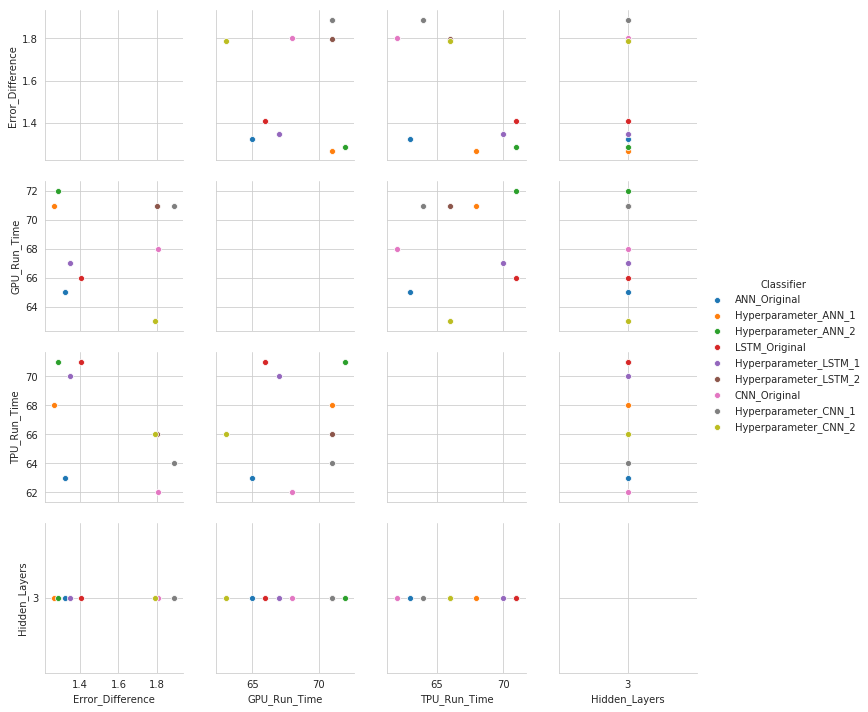

In [0]:
# Pairplot of all numerical value
sns.pairplot(df_final,hue='Classifier')

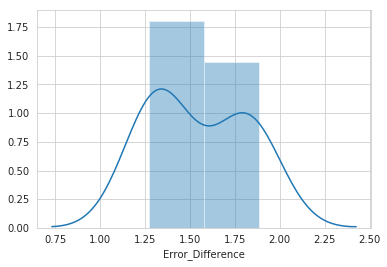

In [0]:
sns.distplot(df_final['Error_Difference'])

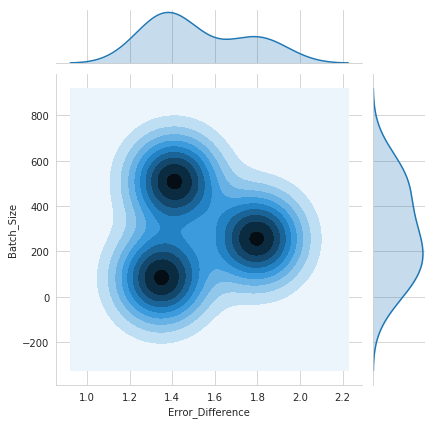

In [0]:
# LSTM error vs batch size
sns.jointplot(x='Error_Difference', y='Batch_Size', data = results_matrix_lstm, kind = 'kde')

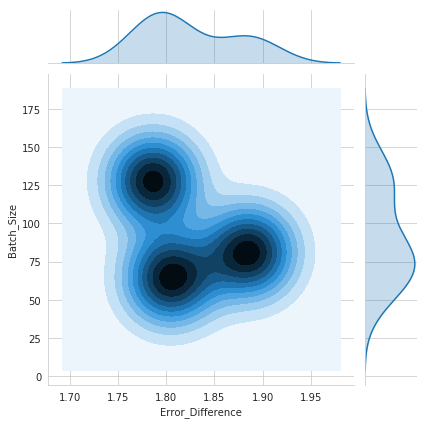

In [0]:
# CNN error vs batch size
sns.jointplot(x='Error_Difference', y='Batch_Size', data = results_matrix_cnn, kind = 'kde')